In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
ticker = 'AAPL'
data = yf.download(ticker, start='2023-01-01', end='2023-12-31')


[*********************100%%**********************]  1 of 1 completed


In [2]:
# calculate 50 day and 200 day sma
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['SMA_200'] = data['Close'].rolling(window=200).mean()


In [3]:
# calculate the 20-day EMA
data['EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()


In [4]:
def calculate_rsi(data, window=14):
    delta = data['Close'].diff(1)
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avggain = pd.Series(gain).rolling(window=window).mean()
    avgloss = pd.Series(loss).rolling(window=window).mean()

    rs = avggain / avgloss
    rsi = 100 - (100 / (1 + rs))

    return rsi

data['RSI_14'] = calculate_rsi(data)


In [5]:
# calculate MACD
data['EMA_12'] = data['Close'].ewm(span=12, adjust=False).mean()
data['EMA_26'] = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['EMA_12'] - data['EMA_26']

# calculate signal line
data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()


In [7]:
# calculate bollinger bands
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['STD_20'] = data['Close'].rolling(window=20).std()

data['Upper Band'] = data['SMA_20'] + (2 * data['STD_20'])
data['Lower Band'] = data['SMA_20'] - (2 * data['STD_20'])


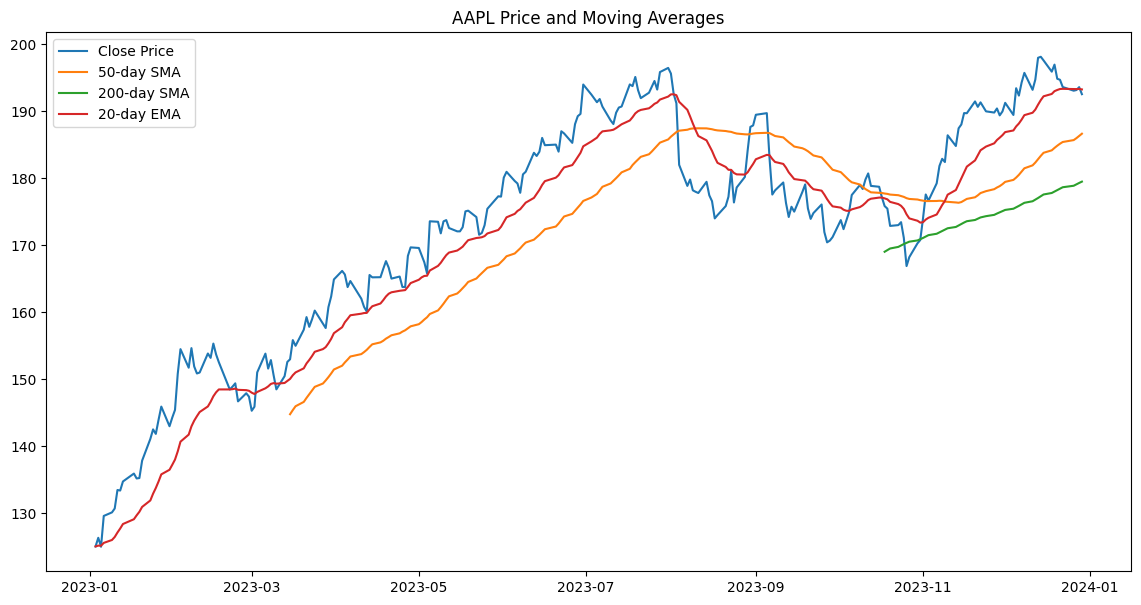

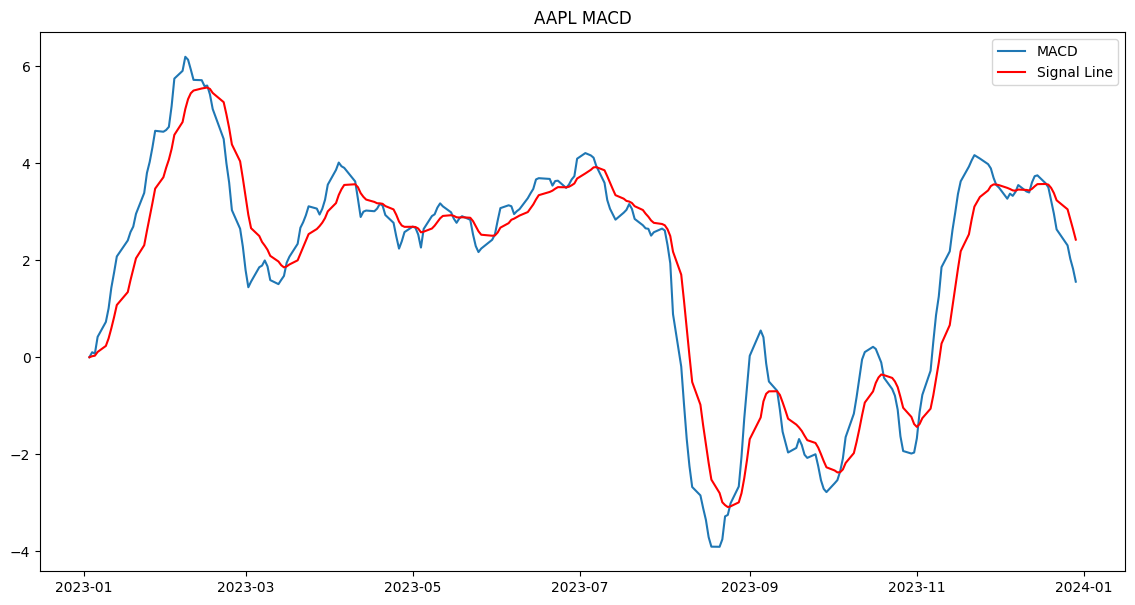

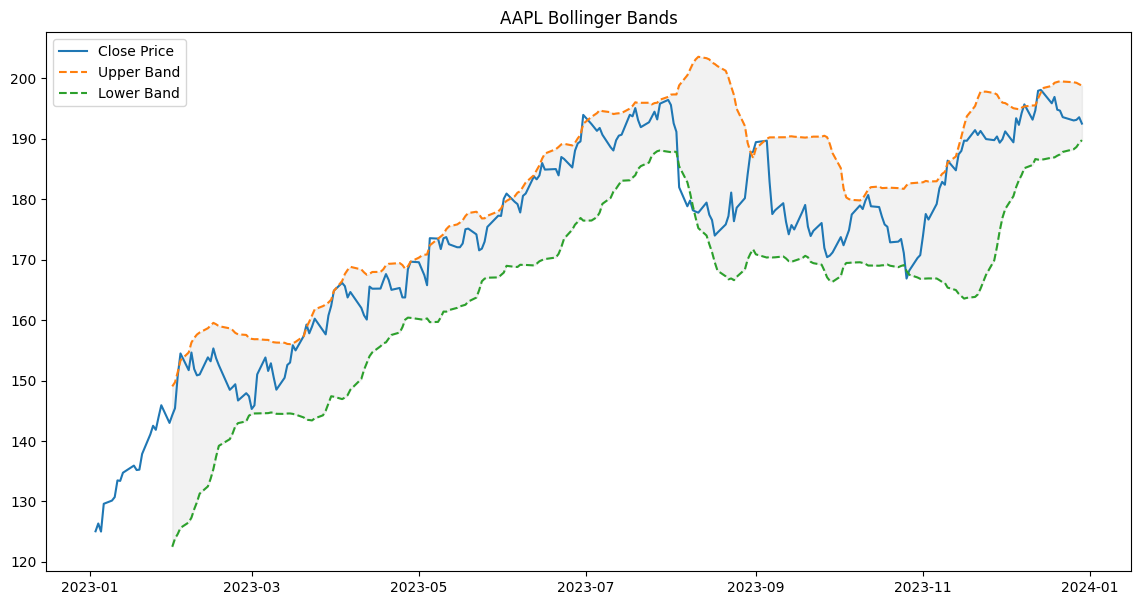

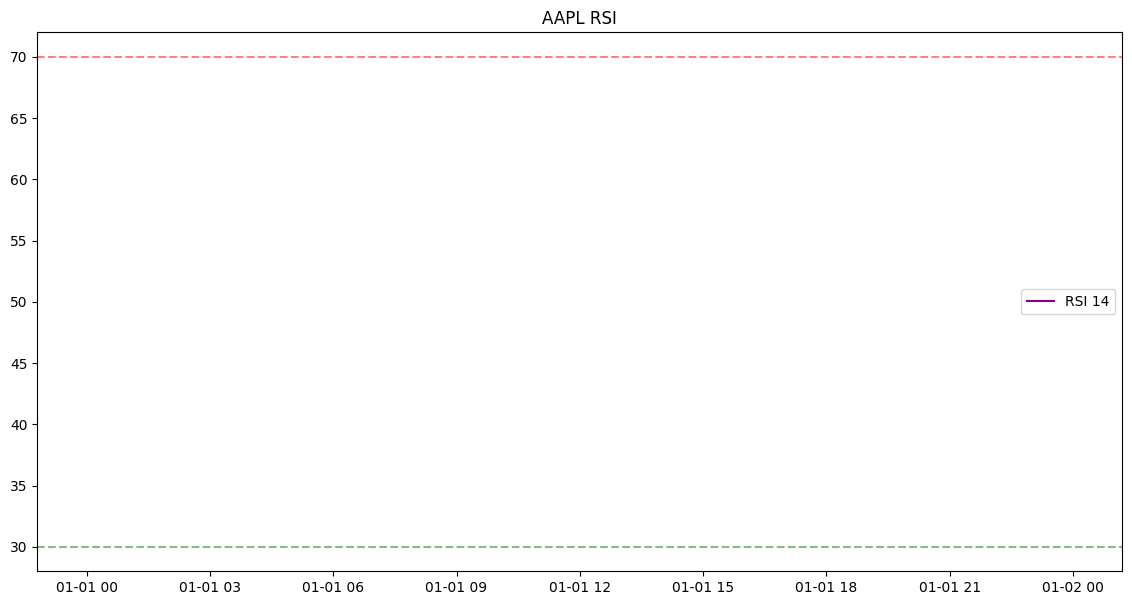

In [9]:
import matplotlib.pyplot as plt

# plot closing price, SMA, and EMA
plt.figure(figsize=(14,7))
plt.plot(data['Close'], label='Close Price')
plt.plot(data['SMA_50'], label='50-day SMA')
plt.plot(data['SMA_200'], label='200-day SMA')
plt.plot(data['EMA_20'], label='20-day EMA')
plt.title(f'{ticker} Price and Moving Averages')
plt.legend()
plt.show()

# plotting MACD and signal line
plt.figure(figsize=(14,7))
plt.plot(data['MACD'], label='MACD')
plt.plot(data['Signal_Line'], label='Signal Line', color='red')
plt.title(f'{ticker} MACD')
plt.legend()
plt.show()

# plotting bollinger bands
plt.figure(figsize=(14,7))
plt.plot(data['Close'], label='Close Price')
plt.plot(data['Upper_Band'], label='Upper Band', linestyle='--')
plt.plot(data['Lower_Band'], label='Lower Band', linestyle='--')
plt.fill_between(data.index, data['Lower_Band'], data['Upper_Band'], color='gray', alpha=0.1)
plt.title(f'{ticker} Bollinger Bands')
plt.legend()
plt.show()

# plotting RSI
plt.figure(figsize=(14,7))
plt.plot(data['RSI_14'], label='RSI 14', color='purple')
plt.axhline(70, linestyle='--', alpha=0.5, color='red')
plt.axhline(30, linestyle='--', alpha=0.5, color='green')
plt.title(f'{ticker} RSI')
plt.legend()
plt.show()


In [10]:
# buying when RSI crosses below 30 and selling when RSI crosses above 70
data['RSI_Buy_Signal'] = np.where(data['RSI_14'] < 30, 1, 0)
data['RSI_Sell_Signal'] = np.where(data['RSI_14'] > 70, 1, 0)


In [11]:
# buy when MACD crosses above the signal line and sell when MACD crosses below
data['MACD_Buy_Signal'] = np.where(data['MACD'] > data['Signal_Line'], 1, 0)
data['MACD_Sell_Signal'] = np.where(data['MACD'] < data['Signal_Line'], 1, 0)


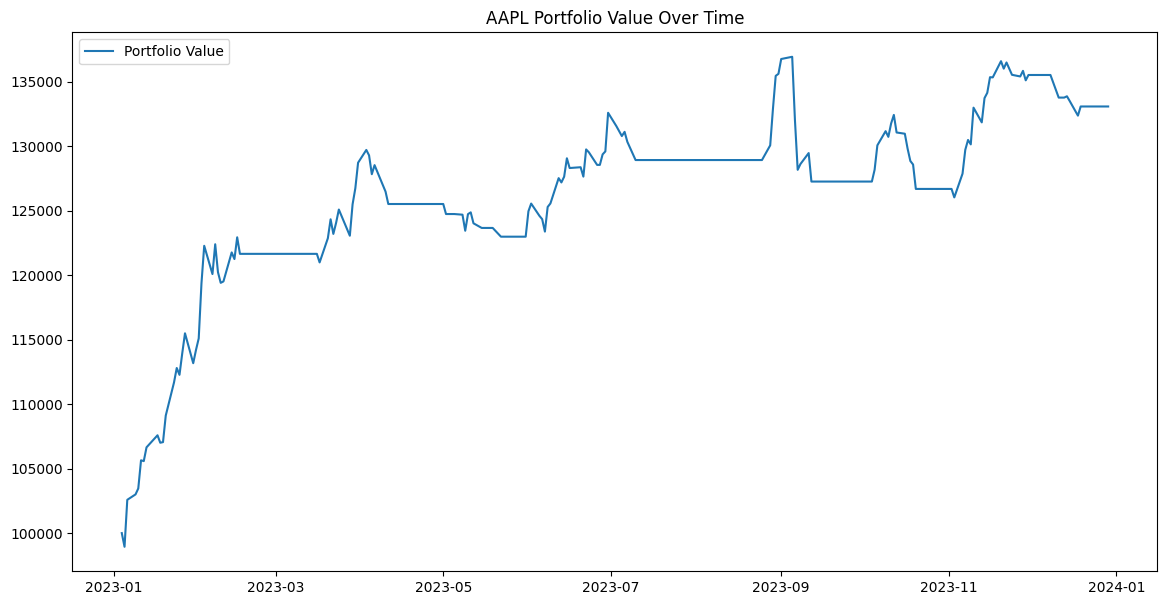

In [15]:
initial_capital = 100000
data['Position'] = 0  # start with no position
data['Position'] = np.where(data['MACD_Buy_Signal'], 1, data['Position'])  # buy signal
data['Position'] = np.where(data['MACD_Sell_Signal'], 0, data['Position'])  # sell signal

data['Daily_Return'] = data['Close'].pct_change()
data['Strategy_Return'] = data['Daily_Return'] * data['Position'].shift(1)

# calculate portfolio value over time
data['Portfolio_Value'] = initial_capital * (1 + data['Strategy_Return']).cumprod()

# plotting the portfolio value
plt.figure(figsize=(14,7))
plt.plot(data['Portfolio_Value'], label='Portfolio Value')
plt.title(f'{ticker} Portfolio Value Over Time')
plt.legend()
plt.show()


In [16]:
# calculate On-Balance Volume (OBV)
data['OBV'] = (np.sign(data['Close'].diff()) * data['Volume']).fillna(0).cumsum()


In [17]:
# calculate True Range (TR)
data['TR'] = np.maximum(data['High'] - data['Low'],
                        np.maximum(abs(data['High'] - data['Close'].shift(1)),
                                   abs(data['Low'] - data['Close'].shift(1))))

# calculate 14-day ATR
data['ATR_14'] = data['TR'].rolling(window=14).mean()


In [19]:
# calculate the 14-day stochastic oscillator
low_14 = data['Low'].rolling(window=14).min()
high_14 = data['High'].rolling(window=14).max()

data['%K'] = 100 * ((data['Close'] - low_14) / (high_14 - low_14))
data['%D'] = data['%K'].rolling(window=3).mean()  # 3-day moving average of %K


In [20]:
# calculate chaikin money flow (CMF)
data['Money_Flow_Volume'] = (data['Close'] - data['Low'] - (data['High'] - data['Close'])) / (data['High'] - data['Low']) * data['Volume']
data['CMF_20'] = data['Money_Flow_Volume'].rolling(window=20).sum() / data['Volume'].rolling(window=20).sum()


In [23]:
import ta

# Calculate Parabolic SAR using the `ta` library
data['Parabolic_SAR'] = ta.trend.PSARIndicator(high=data['High'], low=data['Low'], close=data['Close']).psar()


In [22]:
pip install ta

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29421 sha256=407d57ade912b3486d2575a4336f8cbfa698dfb608b145c7589d40d40241e5fd
  Stored in directory: c:\users\arun bhatnagar\appdata\local\pip\cache\wheels\5c\a1\5f\c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
# bullish engulfing pattern
data['Bullish_Engulfing'] = np.where((data['Open'].shift(1) > data['Close'].shift(1)) &
                                     (data['Open'] < data['Close']) &
                                     (data['Open'] < data['Close'].shift(1)) &
                                     (data['Close'] > data['Open'].shift(1)), 1, 0)


In [26]:
# doji pattern
data['Doji'] = np.where(abs(data['Open'] - data['Close']) <= (data['High'] - data['Low']) * 0.1, 1, 0)


In [27]:
# calculate 20-day volume moving average
data['Volume_MA_20'] = data['Volume'].rolling(window=20).mean()


In [28]:
# Calculate VWAP
data['VWAP'] = (data['Volume'] * (data['High'] + data['Low'] + data['Close']) / 3).cumsum() / data['Volume'].cumsum()


In [29]:
# Combined RSI and MACD signal
data['RSI_MACD_Buy'] = np.where((data['RSI_14'] < 30) & (data['MACD'] > data['Signal_Line']), 1, 0)
data['RSI_MACD_Sell'] = np.where((data['RSI_14'] > 70) & (data['MACD'] < data['Signal_Line']), 1, 0)


In [30]:
# Buy when price crosses above the lower Bollinger Band and RSI is below 30
data['BB_RSI_Buy'] = np.where((data['Close'] < data['Lower_Band']) & (data['RSI_14'] < 30), 1, 0)

# Sell when price crosses below the upper Bollinger Band and RSI is above 70
data['BB_RSI_Sell'] = np.where((data['Close'] > data['Upper_Band']) & (data['RSI_14'] > 70), 1, 0)


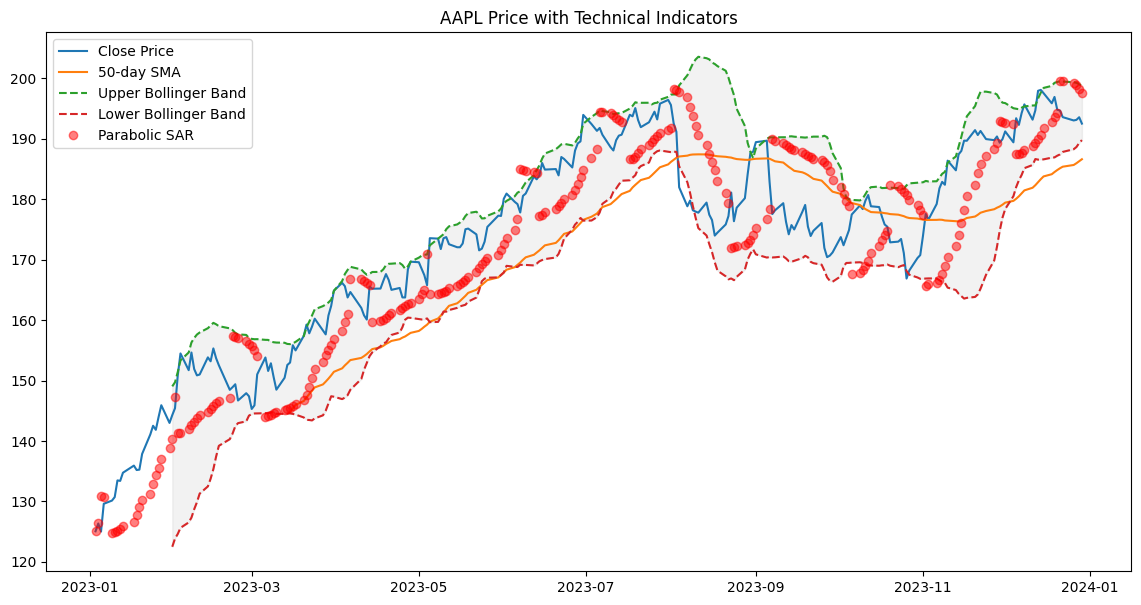

In [32]:
# improved visualisation
plt.figure(figsize=(14,7))
plt.plot(data['Close'], label='Close Price')
plt.plot(data['SMA_50'], label='50-day SMA')
plt.plot(data['Upper_Band'], label='Upper Bollinger Band', linestyle='--')
plt.plot(data['Lower_Band'], label='Lower Bollinger Band', linestyle='--')
plt.fill_between(data.index, data['Lower_Band'], data['Upper_Band'], color='gray', alpha=0.1)
plt.plot(data['Parabolic_SAR'], label='Parabolic SAR', marker='o', linestyle='None', color='red', alpha=0.5)
plt.title(f'{ticker} Price with Technical Indicators')
plt.legend()
plt.show()


In [47]:
pip install ta
